In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [7]:
df = pd.read_csv("./Data/df_final_preprocessed.csv")

# Exploration

In [8]:
df.head()
# import requests
# requests.get('https://www.google.com/')

,No of Days Stayed,Net Amt,settlement_delay,age,Start_year,Start_month,Start_week,Start_day,Start_dayofweek,Reported_year,...,Residence Location_PATIALA,Residence Location_RUPNAGAR,Residence Location_S.A.S Nagar,Residence Location_SANGRUR,Residence Location_SRI MUKTSAR SAHIB,Residence Location_Shahid Bhagat Singh Nagar,Residence Location_Tarn Taran,Reject status more than 3 months_0,Reject status more than 3 months_1,FraudFound
0,0.176955,0.021340,0.386719,1.0,0.0,0.181818,0.176471,0.300000,1.000000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.008230,0.019917,0.327148,1.0,1.0,0.454545,0.470588,0.466667,0.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,0.004115,0.005691,0.351562,0.0,0.0,0.909091,0.921569,0.833333,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.020576,0.019917,0.188477,1.0,1.0,0.454545,0.470588,0.666667,1.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4,0.004115,0.021340,0.354492,1.0,1.0,0.000000,0.058824,0.633333,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [9]:
df.isnull().values.any()

False

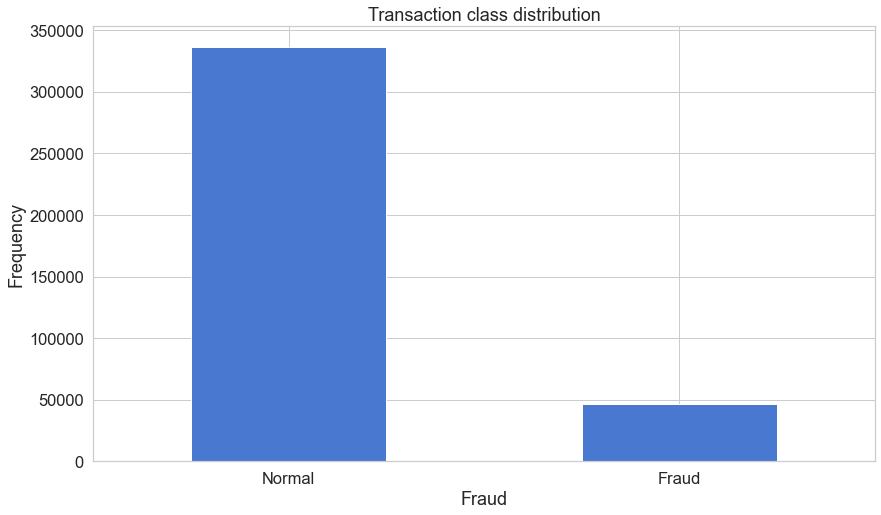

In [10]:
count_classes = pd.value_counts(df['FraudFound'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("FraudFound")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [11]:
frauds = df[df.FraudFound == 1]
normal = df[df.FraudFound == 0]

In [12]:
frauds.shape

(46400, 99)

In [13]:
normal.shape

(336187, 99)

How different are the amount of money used in different transaction classes?

In [14]:
frauds['Net Amt'].describe()

count    46400.000000
mean         0.033577
std          0.064470
min          0.000000
25%          0.004837
50%          0.006829
75%          0.028454
max          0.735524
Name: Net Amt, dtype: float64

In [15]:
normal['Net Amt'].describe()

count    336187.000000
mean          0.030668
std           0.049827
min           0.000000
25%           0.005691
50%           0.015365
75%           0.030730
max           1.000000
Name: Net Amt, dtype: float64

Let's have a more graphical representation:

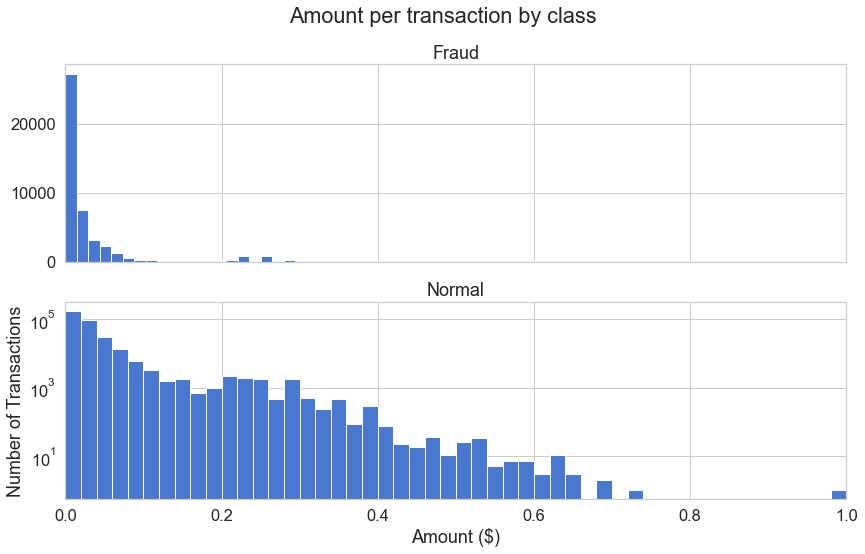

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds['Net Amt'], bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal['Net Amt'], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 1))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

In [18]:
# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# f.suptitle('Time of transaction vs Amount by class')

# ax1.scatter(frauds.Time, frauds.Amount)
# ax1.set_title('Fraud')

# ax2.scatter(normal.Time, normal.Amount)
# ax2.set_title('Normal')

# plt.xlabel('Time (in Seconds)')
# plt.ylabel('Amount')
# plt.show()

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

<iframe width="100%" height="480" src="https://www.youtube.com/embed/FzS3tMl4Nsc" frameborder="0" allowfullscreen></iframe>

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [19]:
from sklearn.preprocessing import StandardScaler

# data = df.drop(['Time'], axis=1)

# data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

data=df

In [20]:
data

,No of Days Stayed,Net Amt,settlement_delay,age,Start_year,Start_month,Start_week,Start_day,Start_dayofweek,Reported_year,...,Residence Location_PATIALA,Residence Location_RUPNAGAR,Residence Location_S.A.S Nagar,Residence Location_SANGRUR,Residence Location_SRI MUKTSAR SAHIB,Residence Location_Shahid Bhagat Singh Nagar,Residence Location_Tarn Taran,Reject status more than 3 months_0,Reject status more than 3 months_1,FraudFound
0,0.176955,0.021340,0.386719,1.0,0.0,0.181818,0.176471,0.300000,1.000000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.008230,0.019917,0.327148,1.0,1.0,0.454545,0.470588,0.466667,0.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,0.004115,0.005691,0.351562,0.0,0.0,0.909091,0.921569,0.833333,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.020576,0.019917,0.188477,1.0,1.0,0.454545,0.470588,0.666667,1.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4,0.004115,0.021340,0.354492,1.0,1.0,0.000000,0.058824,0.633333,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382582,0.004115,0.021340,0.140625,0.0,0.0,0.818182,0.803922,0.433333,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
382583,0.016461,0.035851,0.222656,1.0,1.0,0.000000,0.078431,1.000000,0.666667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
382584,0.000000,0.002845,0.623047,0.0,0.0,0.818182,0.843137,1.000000,0.500000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
382585,0.024691,0.068289,0.332031,1.0,1.0,0.727273,0.705882,0.200000,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [21]:
# data = data.replace({'FraudFound': {'No': 0, 'Yes': 1}})

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [22]:
data

,No of Days Stayed,Net Amt,settlement_delay,age,Start_year,Start_month,Start_week,Start_day,Start_dayofweek,Reported_year,...,Residence Location_PATIALA,Residence Location_RUPNAGAR,Residence Location_S.A.S Nagar,Residence Location_SANGRUR,Residence Location_SRI MUKTSAR SAHIB,Residence Location_Shahid Bhagat Singh Nagar,Residence Location_Tarn Taran,Reject status more than 3 months_0,Reject status more than 3 months_1,FraudFound
0,0.176955,0.021340,0.386719,1.0,0.0,0.181818,0.176471,0.300000,1.000000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.008230,0.019917,0.327148,1.0,1.0,0.454545,0.470588,0.466667,0.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,0.004115,0.005691,0.351562,0.0,0.0,0.909091,0.921569,0.833333,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.020576,0.019917,0.188477,1.0,1.0,0.454545,0.470588,0.666667,1.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4,0.004115,0.021340,0.354492,1.0,1.0,0.000000,0.058824,0.633333,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382582,0.004115,0.021340,0.140625,0.0,0.0,0.818182,0.803922,0.433333,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
382583,0.016461,0.035851,0.222656,1.0,1.0,0.000000,0.078431,1.000000,0.666667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
382584,0.000000,0.002845,0.623047,0.0,0.0,0.818182,0.843137,1.000000,0.500000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
382585,0.024691,0.068289,0.332031,1.0,1.0,0.727273,0.705882,0.200000,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [23]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.FraudFound == 0]
X_train = X_train.drop(['FraudFound'], axis=1)

y_test = X_test['FraudFound']
X_test = X_test.drop(['FraudFound'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [24]:
X_train.shape

(268925, 98)

# Building the model



In [25]:
input_dim = X_train.shape[1]
encoding_dim = 140
print(input_dim)

98


In [26]:
input_layer = Input(shape=(input_dim, ), name = "InputLayer")

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l2(10e-5), name = "encoder")(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="relu", name = "hidden")(encoder)

# decoder = Dense(int(encoding_dim / 2), activation='tanh', name = "decoder1")(encoder)
# decoder = Dense(int(encoding_dim), activation='tanh', name = "decoder")(encoder)
# decoder = Dense(input_dim, activation='relu', name = "output")(decoder)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, 98)                0         
_________________________________________________________________
encoder (Dense)              (None, 140)               13860     
_________________________________________________________________
dense_1 (Dense)              (None, 98)                13818     
Total params: 27,678
Trainable params: 27,678
Non-trainable params: 0
_________________________________________________________________


Let's train our model for 40 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [29]:
%%time

nb_epoch = 40
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_carclaims.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 268925 samples, validate on 76518 samples
Epoch 1/40
268925/268925 [==============================] - 24s 89us/step - loss: 0.0010 - accuracy: 0.0692 - val_loss: 0.0556 - val_accuracy: 0.0331
Epoch 2/40
268925/268925 [==============================] - 20s 74us/step - loss: 9.9375e-04 - accuracy: 0.0719 - val_loss: 0.0604 - val_accuracy: 0.1003
Epoch 3/40
268925/268925 [==============================] - 20s 73us/step - loss: 9.7782e-04 - accuracy: 0.0690 - val_loss: 0.0642 - val_accuracy: 0.0267
Epoch 4/40
268925/268925 [==============================] - 21s 79us/step - loss: 9.6919e-04 - accuracy: 0.0710 - val_loss: 0.0664 - val_accuracy: 0.0433
Epoch 5/40
268925/268925 [==============================] - 20s 76us/step - loss: 9.5948e-04 - accuracy: 0.0724 - val_loss: 0.0690 - val_accuracy: 0.0376
Epoch 6/40
268925/268925 [==============================] - 21s 78us/step - loss: 9.4844e-04 - accuracy: 0.0704 - val_loss: 0.0720 - val_accuracy: 0.0343
Epoch 7/40
268925/268925 [===

In [ ]:
# autoencoder = load_model('model_carclaims.h5')

# Evaluation

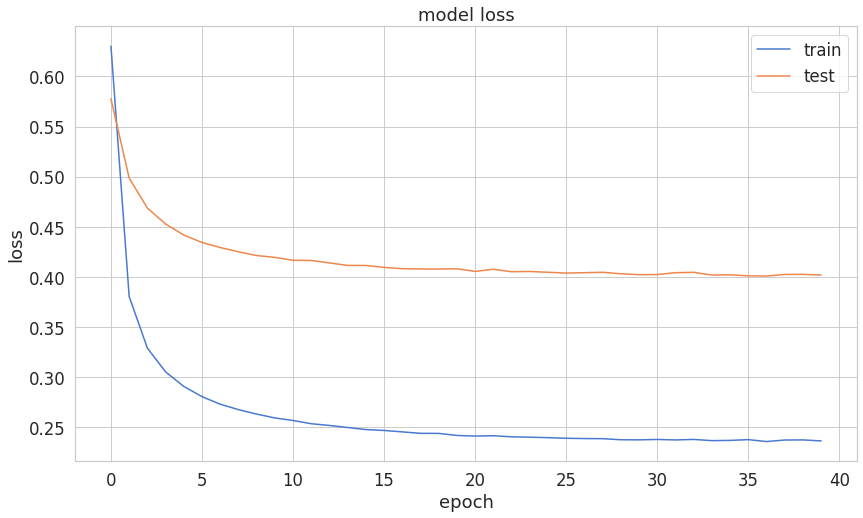

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [ ]:
predictions = autoencoder.predict(X_test)

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [ ]:
error_df

,reconstruction_error,true_class
4291,0.109550,0
7874,0.182249,0
3325,0.129184,0
4048,0.217981,0
15203,0.282698,0
...,...,...
9747,0.143303,0
8574,0.147281,0
6408,0.147057,0
5438,0.249321,0


## Reconstruction error without fraud

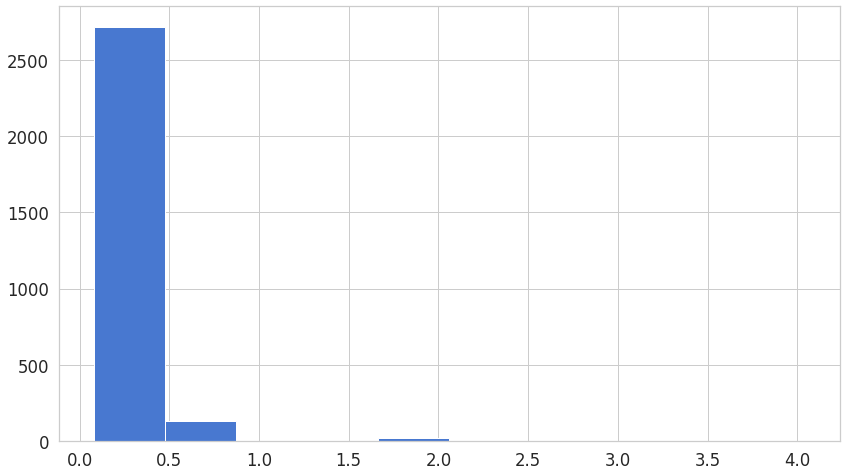

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

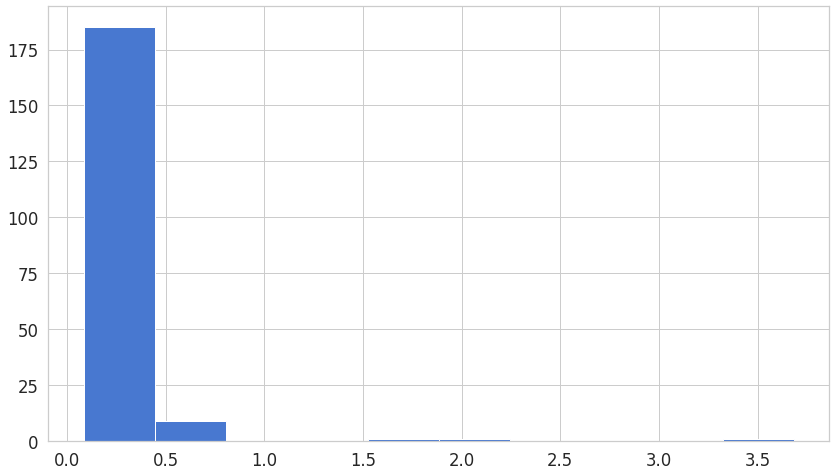

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

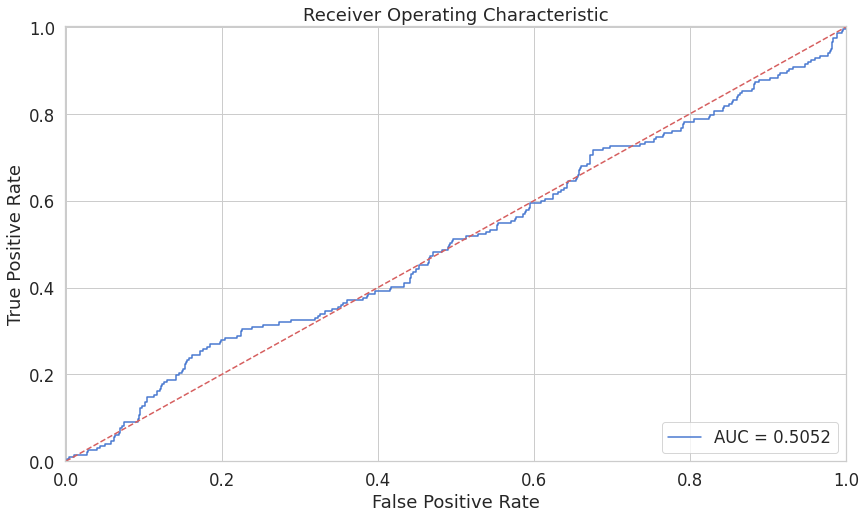

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [ ]:
thresholds

array([3.16281238e+02, 3.15281238e+02, 3.83780833e+00, 3.68322774e+00,
       2.08688348e+00, 2.02686552e+00, 1.78625678e+00, 1.76497269e+00,
       6.43118190e-01, 6.41305191e-01, 6.27128148e-01, 6.26322494e-01,
       5.87616984e-01, 5.87165567e-01, 5.69085794e-01, 5.68236767e-01,
       5.49348435e-01, 5.48537203e-01, 5.07699742e-01, 4.95069804e-01,
       4.58836634e-01, 4.55013273e-01, 4.54490036e-01, 4.53005316e-01,
       4.47102919e-01, 4.46794313e-01, 4.26266388e-01, 4.25292776e-01,
       4.22248404e-01, 4.21915814e-01, 4.21564378e-01, 4.20618543e-01,
       4.11545226e-01, 4.11153850e-01, 3.98623343e-01, 3.95127040e-01,
       3.57747877e-01, 3.57583682e-01, 3.56555837e-01, 3.56233520e-01,
       3.55315334e-01, 3.55024090e-01, 3.53875069e-01, 3.52824478e-01,
       3.52240321e-01, 3.52054726e-01, 3.45886493e-01, 3.44415373e-01,
       3.37013218e-01, 3.36209174e-01, 3.34479307e-01, 3.31963036e-01,
       3.15744032e-01, 3.15271787e-01, 3.07541520e-01, 3.04645822e-01,
      

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

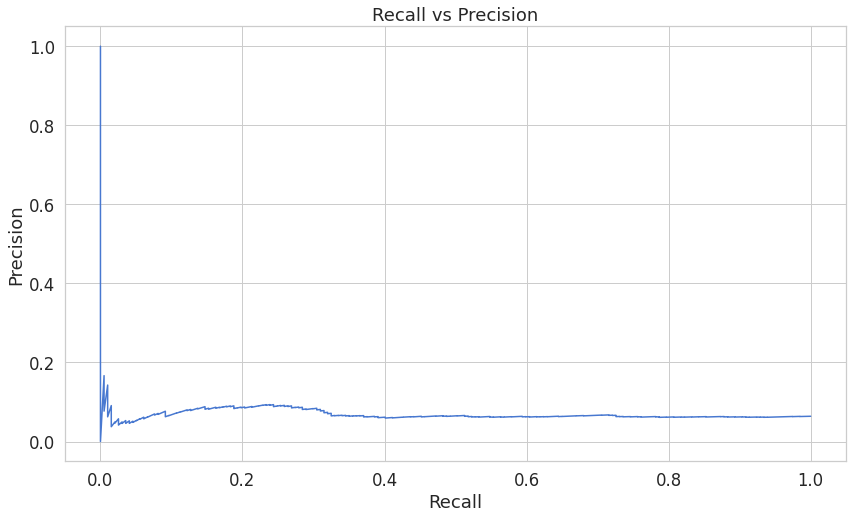

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

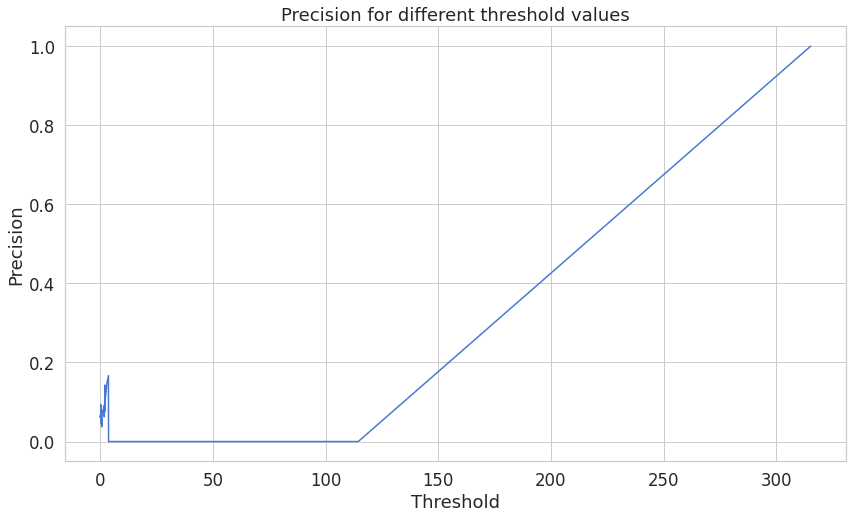

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

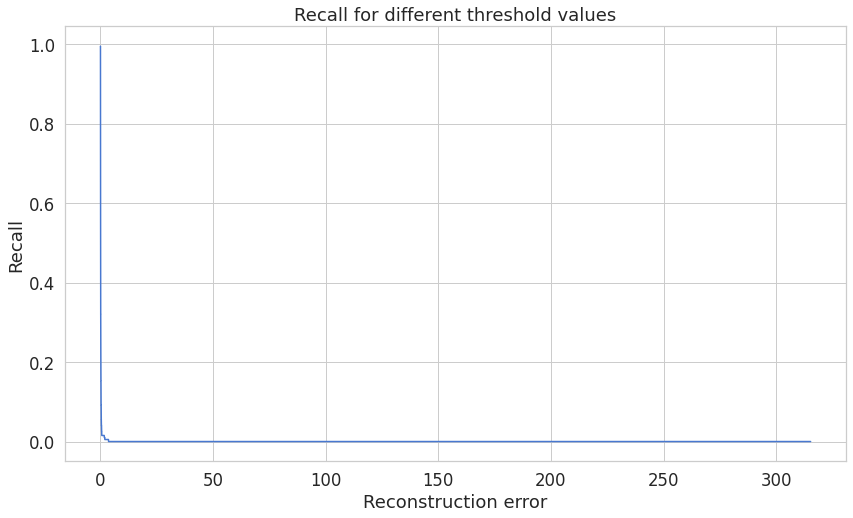

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [ ]:
threshold = 1.5

And see how well we're dividing the two types of transactions:

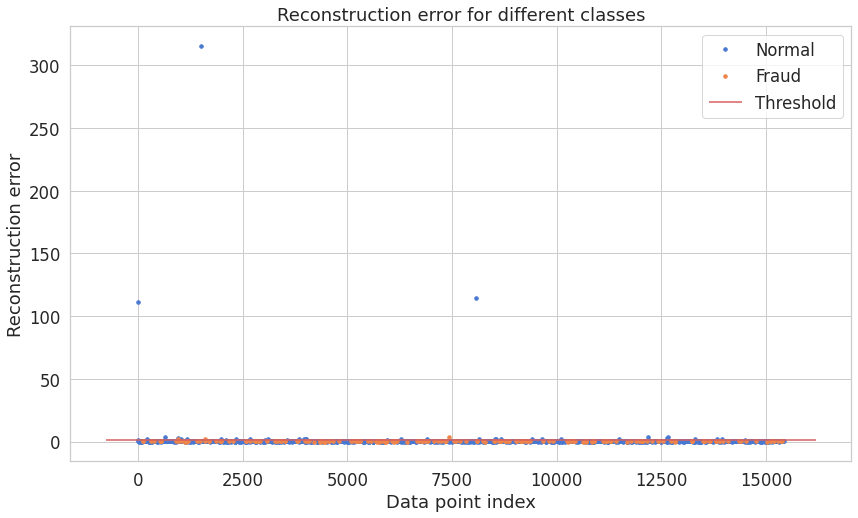

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

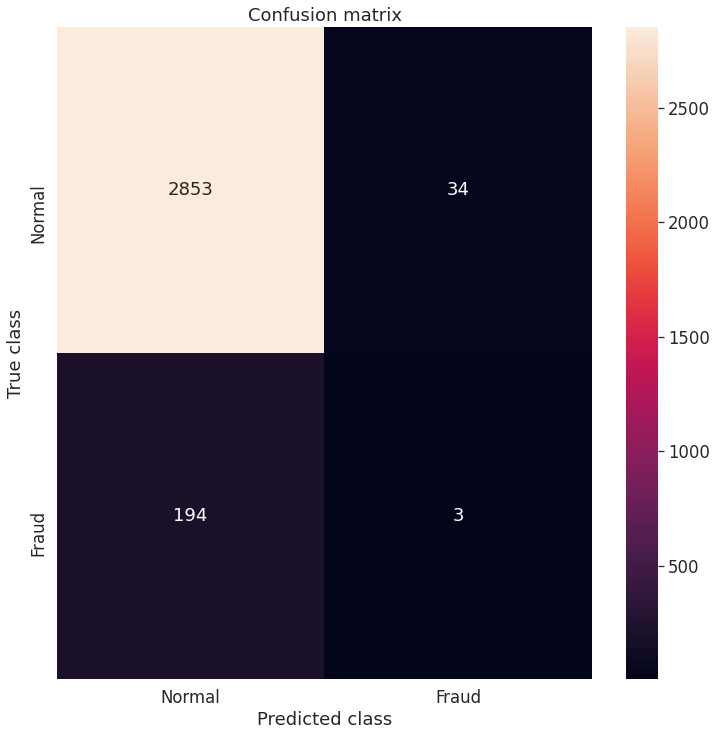

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)